100%|██████████| 2948/2948 [00:06<00:00, 479.39it/s]


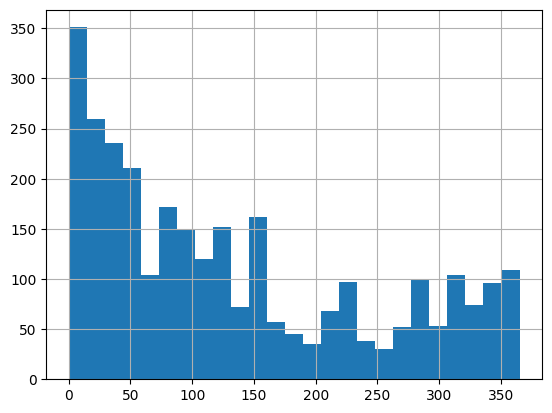

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, ClassificationMandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

n_classes = 4
class_step = 365 / n_classes
name = f"exp_classif_{n_classes}"

dataset = ClassificationMandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, n_classes=n_classes, days_step=class_step)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm
import numpy as np

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
batch_size = 64
num_epochs = 100
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, output_dim=n_classes, sigmoid=False, n_lin=6, lin_start=2048)

# Loss function
criterion = nn.CrossEntropyLoss()
val_criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)

# Training loop
train = False

if train:
    best_val = np.inf
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)

        if val_loss < best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(model, "classif", exp_name=name)
        else:
            print(f"Val loss did not improved from {best_val:.4f}")    


        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f} - "
              f"Val L1: {val_loss:.4f}")

Using device: cuda


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load, softmax

model = load(model, "classif", exp_name=name)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 0

y_true = []
y_pred = []

model.eval()

# Perform inference on validation images
for i, (images, targets) in tqdm(enumerate(val_loader)):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    output_prob = softmax(outputs.squeeze().detach().cpu().numpy())
    predicted_class = np.argmax(output_prob)

    real_class = np.argmax(targets.squeeze().cpu().numpy())
    
    y_true.append(real_class)
    y_pred.append(output_prob)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted class:", predicted_class)
    print("Real class:", real_class)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

590it [00:08, 66.98it/s]


Accuracy: 0.8424
Precision: 0.7786
Recall: 0.7807
F1-score: 0.7760


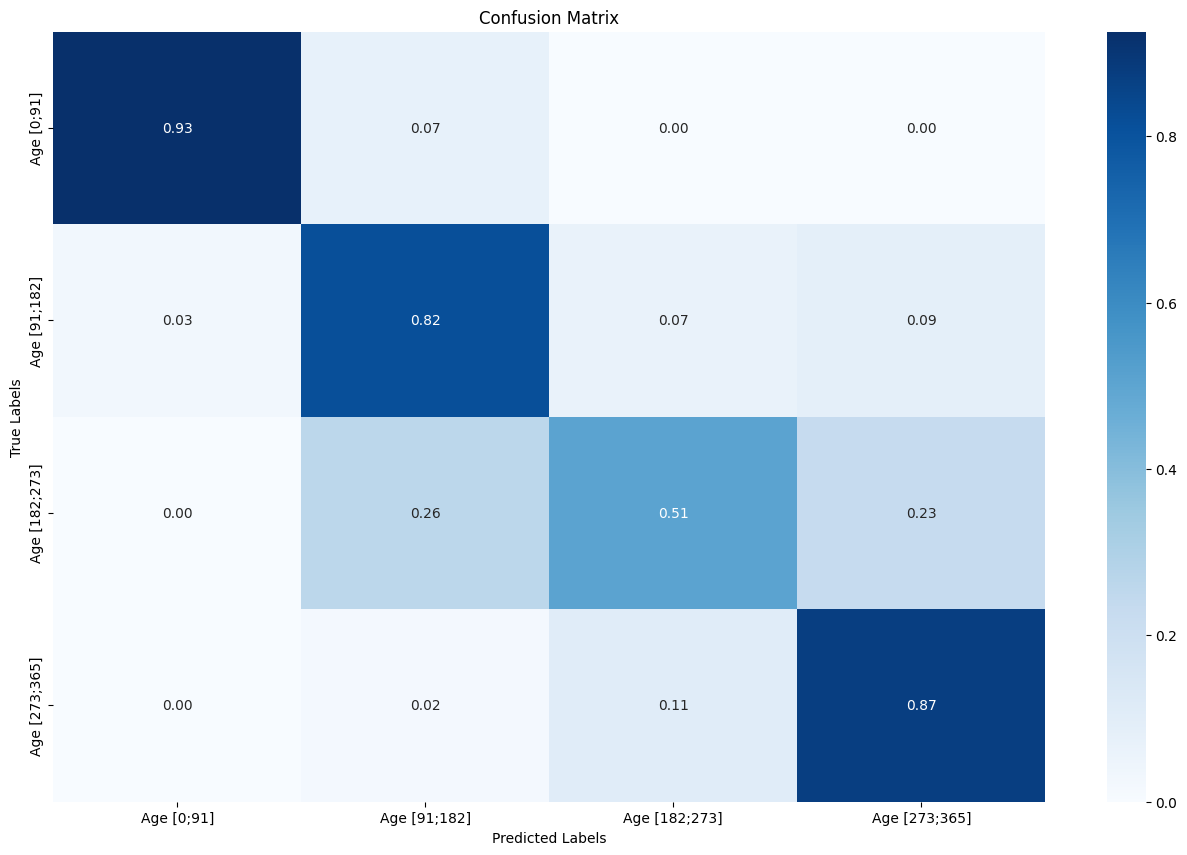

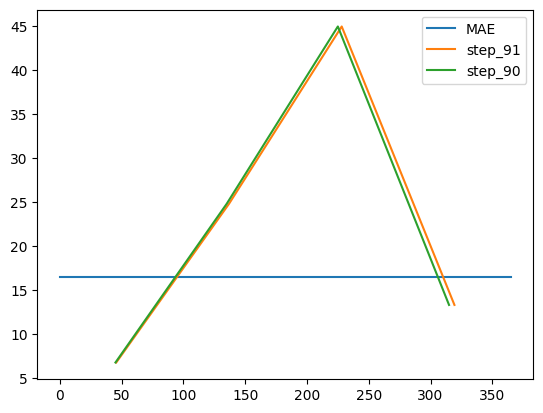

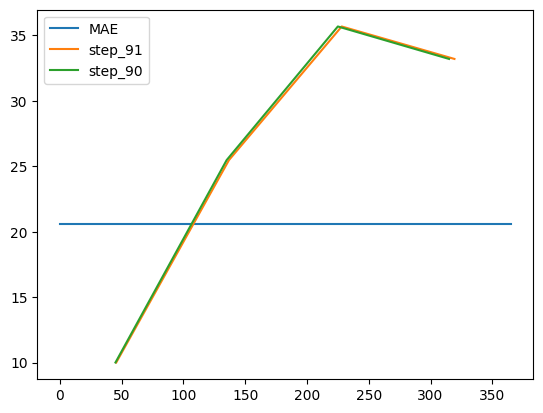

{'vgg_face_three_months': {'vgg_face_three_months_as_regression': {'argmax': {'vgg_face_three_months_as_regression_mae': 16.53813559322034,
    'vgg_face_three_months_as_regression_mae_steps': {91.25: [(45.625,
       6.776595744680851),
      (136.875, 24.801470588235293),
      (228.125, 44.95652173913044),
      (319.375, 13.315533980582524)],
     90: [(45.0, 6.776595744680851),
      (135.0, 24.801470588235293),
      (225.0, 44.95652173913044),
      (315.0, 13.315533980582524)]}},
   'weighted_scalars': {'vgg_face_three_months_as_regression_mae': 20.62684714227964,
    'vgg_face_three_months_as_regression_mae_steps': {91.25: [(45.625,
       10.005900895062148),
      (136.875, 25.478484780374696),
      (228.125, 35.68943104253841),
      (319.375, 33.20903970360537)],
     90: [(45.0, 10.005900895062148),
      (135.0, 25.478484780374696),
      (225.0, 35.68943104253841),
      (315.0, 33.20903970360537)]}}},
  'vgg_face_three_months_classification': {'precision': 0.778561079

In [4]:
from mandrill.evaluations import standard_classification_evaluation
standard_classification_evaluation(y_true, y_pred, class_step, n_classes, "vgg_face_three_months")